In [1]:
from memory_profiler import memory_usage
from time import sleep
import torch
from matplotlib import pyplot as plt
import numpy as np
import timeit

In [36]:
def func1(var_1,var_2,normedweight,power):
    xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()
    del xx,yy

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)
    del amat

    xx = var_2.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()
    del xx,yy

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)
    del bmat

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)
    del Bmat, Amat

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    return dCorr
def func2(var_1,var_2,normedweight,power):
    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    return dCorr

In [37]:
n = int(4e4)
var_1 = torch.rand(n)
var_2 = torch.rand(n)
normedweight = torch.rand(n)
power = 2

In [40]:
ns = 2**np.arange(15)
mems1= []
mems2= []
for n in ns:
    mem_usage1 = memory_usage((func1,(var_1[:n],var_2[:n],normedweight[:n],power),),interval=0.1)
    mem_usage2 = memory_usage((func2,(var_1[:n],var_2[:n],normedweight[:n],power),),interval=0.1)
    mems1.append(mem_usage1)
    mems2.append(mem_usage2)

Text(0.5, 0, 'batch_size')

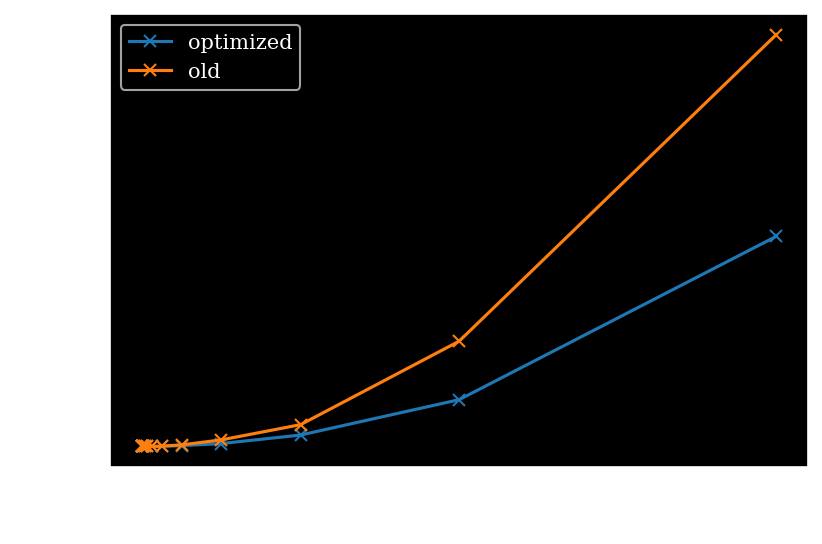

In [44]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)
ax.errorbar(ns,[max(x) for x in mems1],label="optimized",c='tab:blue',marker="x")
ax.errorbar(ns,[max(x) for x in mems2],label="old",c='tab:orange',marker="x")
ax.legend()
ax.set_ylabel("max mem usage [MB]")
ax.set_xlabel("batch_size")

Text(0.5, 1.0, 'memory usage at n=1e4')

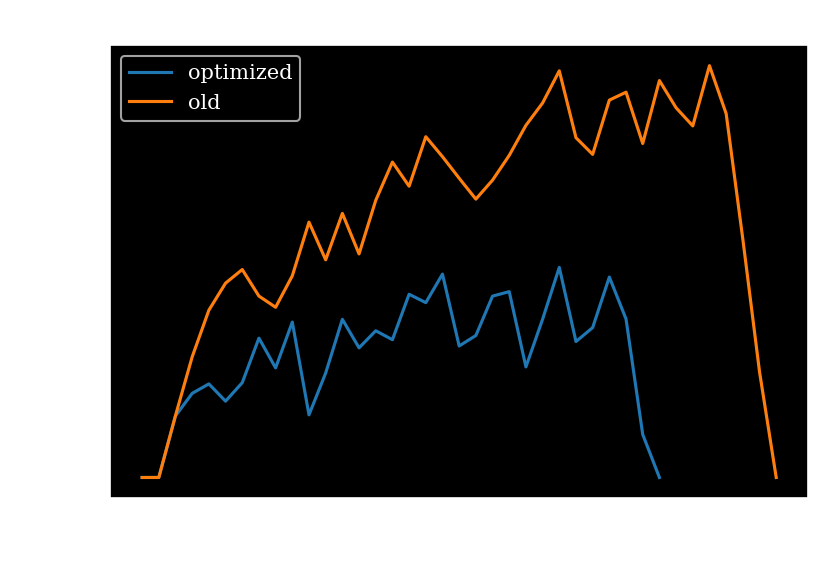

In [45]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)
ax.plot(np.cumsum(len(mem_usage1)*[0.1]),mem_usage1,label="optimized",c='tab:blue')
ax.plot(np.cumsum(len(mem_usage2)*[0.1]),mem_usage2,label="old",c='tab:orange')
ax.legend()
ax.set_xlabel("time [s]")
ax.set_ylabel("mem [MB]")
ax.set_title("memory usage at n=1e4")

In [25]:
ns = 2**np.arange(15)
times1= []
times2= []
for n in ns:
    time = timeit.timeit(lambda: func1(var_1[:n],var_2[:n],normedweight[:n],power),number=10
                         #'gc.enable()'
                        )
    times1.append(time)
for n in ns:
    time = timeit.timeit(lambda: func2(var_1[:n],var_2[:n],normedweight[:n],power), number=10,
                         #'gc.enable()'
                        )
    times2.append(time)

Text(0.5, 0, 'batch_size')

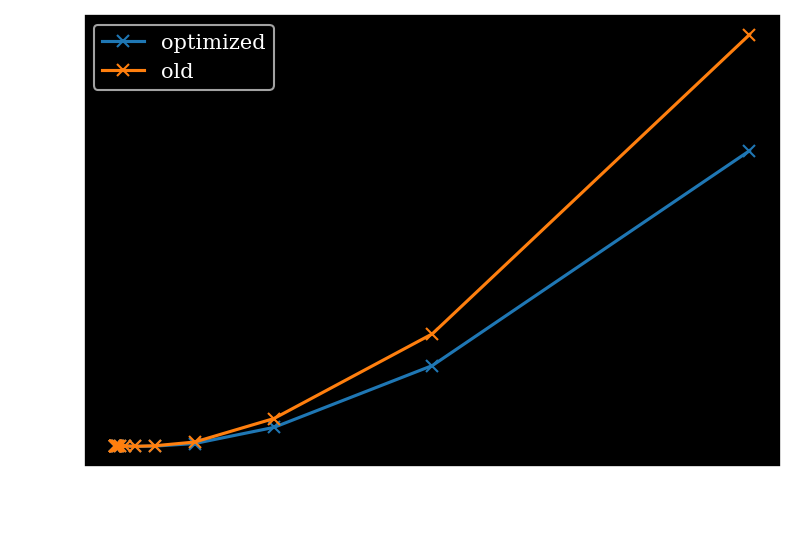

In [46]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)
ax.errorbar(ns,times1,label="optimized",c='tab:blue',marker="x")
ax.errorbar(ns,times2,label="old",c='tab:orange',marker="x")
ax.legend()
ax.set_ylabel("time [s]")
ax.set_xlabel("batch_size")